# Data Extraction

In [16]:
import os
from pathlib import Path

import earthaccess as ea
import netCDF4 as nc
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
from dotenv import load_dotenv, find_dotenv
from matplotlib.path import Path as PolygonPath
from src.services.utils import get_logger
from src.services.google import Google

logger = get_logger()
env_loaded = load_dotenv(find_dotenv())
if env_loaded:
    logger.info("Environment variables loaded successfully.")
else:
    logger.error("Failed to load environment variables.")

2025-10-04T16:50:50.336877-0500 | INFO | Environment variables loaded successfully.


## Get data from different sources

### Earth data login

In [2]:
auth = ea.login(persist=True)

In [12]:
short_name = "TEMPO_NO2_L3"  # collection name to search for in the EarthData
version = "V03"

# Point of interest: NASA Langley Research Center, HamptonVA, USA
# latitude 37.1036 deg, longitude -76.3868 deg
# POI_lat = 37.1036
# POI_lon = -76.3868

# generic location, somewhere in the middle of the USA
POI_lat = 38.89
POI_lon = -96.0
date_start = "2025-01-01 00:00:00"
date_end = "2025-01-01 23:59:59"
lon_lat1 = (-124.3175932, 41.9956687)
lon_lat2 = (-114.0125075, 34.2200353)
lon_lat3 = (-120.0016328, 41.9936434)
lon_lat4 = (-124.3175932, 41.9956687) 
polygon_coords = [
    (-120.0091050, 41.9727325),
    (-124.6045661, 41.8898826),
    (-120.4462801, 33.9044735),
    (-117.1073262, 32.6184122),
    (-114.2955756, 32.6554188),
    (-114.1637748, 34.3047333),
    (-114.7349117, 35.0995465),
    (-120.0948112, 39.0254518),
    (-120.0091050, 41.9727325),
]

In [13]:
results = ea.search_data(
    short_name=short_name,
    version=version,
    temporal=(date_start, date_end),
    polygon=polygon_coords,
)
print(len(results))

10


In [7]:
data_extraction_path = Path("./data/data_extraction/")
if data_extraction_path.exists() and data_extraction_path.is_dir():
    for file in data_extraction_path.iterdir():
        if file.is_file():
            file.unlink()
else:
    data_extraction_path.mkdir(parents=True, exist_ok=True)
file_paths = []
for result in results:
    file = ea.download(result, local_path=str(data_extraction_path))
    file_paths.append(str(file[0]))

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1346.05it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:15<00:00, 15.65s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 8848.74it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1908.24it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:16<00:00, 16.75s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 9986.44it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1253.15it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:16<00:00, 16.28s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 28728.11it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1852.61it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:16<00:00, 16.47s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 28728.11it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3113.81it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:37<00:00, 37.00s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 

In [7]:
# Get all the file paths in the folder data/data_extraction
file_paths = [str(file) for file in data_extraction_path.iterdir() if file.is_file()]
print(f"Number of files downloaded: {len(file_paths)}")

Number of files downloaded: 10


In [8]:
granule_name = str(file_paths[0])
no2_jan_01 = xr.open_dataset(granule_name) \
    .stack(point=("latitude", "longitude")) \
    .to_dataframe().reset_index()
no2_jan_01.head()

,latitude,longitude,time,weight
0,14.01,-167.990005,2025-01-01 18:48:44.022033664,NaN
1,14.01,-167.970001,2025-01-01 18:48:44.022033664,NaN
2,14.01,-167.949997,2025-01-01 18:48:44.022033664,NaN
3,14.01,-167.929993,2025-01-01 18:48:44.022033664,NaN
4,14.01,-167.910004,2025-01-01 18:48:44.022033664,NaN


In [9]:
logger.info(f"Original size: {no2_jan_01.shape[0]}")
no2_jan_01.dropna(inplace=True)
logger.info(f"After dropping NaNs: {no2_jan_01.shape[0]}")
no2_jan_01.head(1)

2025-10-04T16:42:08.253321-0500 | INFO | Original size: 22862500
2025-10-04T16:42:08.561495-0500 | INFO | After dropping NaNs: 8496441


,latitude,longitude,time,weight
1228064,17.17,-96.709999,2025-01-01 18:48:44.022033664,0.016156


In [17]:
# Filter the dataframe to include only points inside the polygon
polygon_path = PolygonPath(polygon_coords)
mask = polygon_path.contains_points(no2_jan_01[['longitude', 'latitude']].values)
no2_jan_01 = no2_jan_01[mask]
logger.info(f"After polygon filter: {no2_jan_01.shape[0]}")

2025-10-04T16:50:53.694365-0500 | INFO | After polygon filter: 107174


In [12]:
google = Google()
_ = google.bigquery.upload_data_from_dataframe(no2_jan_01, dataset="earth_data", table_id="no2_historical")

ValueError: This method requires pyarrow to be installed

In [102]:
1024/141.8

7.221438645980253

In [101]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5311609 entries, 1228076 to 19289281
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   latitude   float32       
 1   longitude  float32       
 2   time       datetime64[ns]
 3   weight     float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 141.8 MB


In [99]:
13*5_000_000*30

1950000000

<Axes: xlabel='longitude', ylabel='weight'>

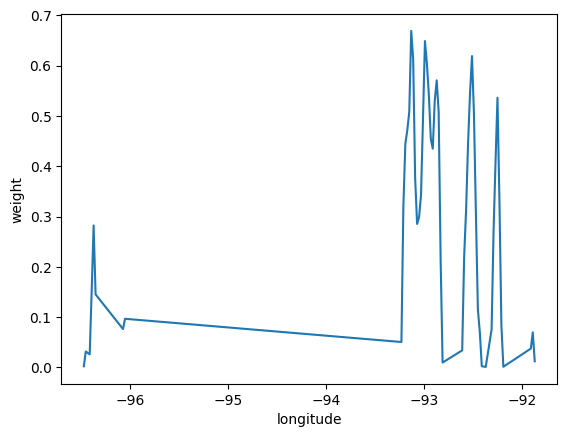

In [98]:
sns.lineplot(x="longitude", y="weight", data=df2[df2["latitude"] == 17.17])

In [97]:
df2[df2["latitude"] == 17.17]

,latitude,longitude,time,weight
1228076,17.17,-96.470001,2025-01-01 12:48:20.024286464,0.002407
1228077,17.17,-96.449997,2025-01-01 12:48:20.024286464,0.031854
1228079,17.17,-96.410004,2025-01-01 12:48:20.024286464,0.026104
1228080,17.17,-96.389999,2025-01-01 12:48:20.024286464,0.151505
1228081,17.17,-96.370003,2025-01-01 12:48:20.024286464,0.282363
1228082,17.17,-96.349998,2025-01-01 12:48:20.024286464,0.145316
1228096,17.17,-96.070000,2025-01-01 12:48:20.024286464,0.076448
1228097,17.17,-96.050003,2025-01-01 12:48:20.024286464,0.096833
1228238,17.17,-93.230003,2025-01-01 12:48:20.024286464,0.050661
1228239,17.17,-93.209999,2025-01-01 12:48:20.024286464,0.321145


In [96]:
df2[df2["latitude"] == 17.17].shape

(52, 4)

In [91]:
df2[~df2['weight'].isna()].shape

(5311609, 4)

In [89]:
df2['weight'].max()

np.float32(4.991369)

In [81]:
ds.latitude.shape[0], ds.longitude.shape[0], ds.time.shape[0]

(2950, 7750, 1)

In [75]:
print(ds.data_vars)      # list all variables
print(ds.coords)         # list coordinates
print(ds.attrs)          # view global metadata
print(ds['tas'])         # view variable metadata

Data variables:
    weight   (latitude, longitude) float32 91MB ...
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * time       (time) datetime64[ns] 8B 2025-01-01T12:48:20.024286464
{'history': '2025-01-01T18:55:51Z: L2_regrid -v /tempo/nas0/sdpc/liveroot/temposdpc/ops4/etc/l3.cfg\n', 'scan_num': np.int32(2), 'time_coverage_start': '2025-01-01T12:48:02Z', 'time_coverage_end': '2025-01-01T13:27:51Z', 'time_coverage_start_since_epoch': np.float64(1419770900.0242865), 'time_coverage_end_since_epoch': np.float64(1419773289.6518493), 'product_type': 'NO2', 'processing_level': '3', 'processing_version': np.int32(3), 'sdpc_version': 'TEMPO_SDPC_v4.4.3', 'production_date_time': '2025-01-01T18:55:52Z', 'begin_date': '2025-01-01', 'begin_time': '12:48:02', 'end_date': '2025-01-01', 'end_time': '13:27:51', 'local_granule_id': 'TEMPO_NO2_L3_V03_20250101T124802Z_S002.nc', '

KeyError: "No variable named 'tas'. Variables on the dataset include ['weight', 'longitude', 'latitude', 'time']"